In [2]:
# Importamos librerias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import re

In [3]:
#levantamos el dataset y verificamos

data = pd.read_csv('../properties_colombia_train.csv')
data.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,geometry
0,861131,CScTjaFiP6yCzS8tFX0ZVA==,Propiedad,2020-12-14,9999-12-31,2020-12-14,6.203000,-75.572000,Colombia,Antioquia,...,NaN,NaN,9.000000e+09,COP,NaN,Hermosa Mansión En El Poblado. Área Construida...,<b>Hermosa Mansión En El Poblado. Área Constru...,Casa,Venta,POINT (-75.572 6.203)
1,200972,DlCxox9+FuugkxS2kBVfJg==,Propiedad,2020-09-16,2021-05-14,2020-09-16,4.722748,-74.073115,Colombia,Cundinamarca,...,NaN,NaN,6.250000e+08,COP,NaN,"APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NORTE",Venta apartamento en piso 16 con vista exterio...,Apartamento,Venta,POINT (-74.0731146 4.7227485)
2,554622,yitN1AigL45gh/K2YSF8rw==,Propiedad,2020-08-19,2020-08-20,2020-08-19,4.709000,-74.030000,Colombia,Cundinamarca,...,NaN,NaN,4.200000e+08,COP,NaN,Apartamento En Venta En Bogota Bella Suiza Cod...,Al entrar a este bonito apartamento interior e...,Casa,Venta,POINT (-74.03 4.709)
3,540321,hELQ9njwODbLMpATXieRdQ==,Propiedad,2020-11-23,2020-11-30,2020-11-23,NaN,NaN,Colombia,Santander,...,NaN,NaN,1.310000e+09,COP,NaN,SE VENDE LOCAL COMERCIAL EN CABECERA DEL LLANO...,Se encuentra ubicado en el sector de la Cabece...,Otro,Venta,POINT EMPTY
4,448920,aBCtKT7LDzt2CxJQ+gVFEA==,Propiedad,2020-10-06,2020-10-07,2020-10-06,NaN,NaN,Colombia,Antioquia,...,NaN,NaN,2.100000e+08,COP,NaN,Apartamento en Venta Ubicado en ITAGUI,Codigo Inmueble 4302 Apartamento con 3 habitac...,Apartamento,Venta,POINT EMPTY


In [4]:
# reservo el valor de la media de precio original en una variable; para referencia posterior.
media_precio_orig = data['price'].mean()
print(media_precio_orig)

643605091.0064613


In [5]:
#vemos una descripcion preliminar de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197549 entries, 0 to 197548
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197549 non-null  int64  
 1   id               197549 non-null  object 
 2   ad_type          197549 non-null  object 
 3   start_date       197549 non-null  object 
 4   end_date         197549 non-null  object 
 5   created_on       197549 non-null  object 
 6   lat              148051 non-null  float64
 7   lon              148051 non-null  float64
 8   l1               197549 non-null  object 
 9   l2               197549 non-null  object 
 10  l3               186517 non-null  object 
 11  l4               45367 non-null   object 
 12  l5               27409 non-null   object 
 13  l6               6867 non-null    object 
 14  rooms            27537 non-null   float64
 15  bedrooms         40525 non-null   float64
 16  bathrooms        156467 non-null  floa

In [6]:
data.describe()

,Unnamed: 0,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,197549.000000,148051.000000,148051.000000,27537.000000,40525.000000,156467.000000,6974.000000,9.802000e+03,1.974860e+05
mean,497437.843851,5.666001,-75.041045,3.291208,3.239062,2.639279,1352.132349,9.483356e+02,6.436051e+08
std,290023.578338,2.196804,1.104575,1.754795,1.985636,1.437174,7713.769352,3.730875e+04,1.944868e+09
min,0.000000,-32.787342,-119.698190,1.000000,0.000000,1.000000,10.000000,1.000000e+00,0.000000e+00
25%,234211.000000,4.582315,-75.645126,3.000000,3.000000,2.000000,72.000000,7.100000e+01,2.000000e+08
50%,507385.000000,4.908611,-75.476654,3.000000,3.000000,2.000000,120.000000,1.140000e+02,3.300000e+08
75%,770037.000000,6.248101,-74.094001,4.000000,4.000000,3.000000,281.000000,2.160000e+02,6.000000e+08
max,993551.000000,34.420334,-67.482570,40.000000,96.000000,20.000000,180000.000000,3.480000e+06,3.450000e+11


## Datos Duplicados

In [7]:
# Revisamos si hay registros duplicados, registros duplicados en la col 'id', o registros duplicados en la col 'Unnamed: 0'
# ya que sobre estas últimas 2 columnas, quizas hubiera info redundante. Ej una propiedad publicada en más de una oportunidad
# con una actualizacion de precio

print(data[data.duplicated()])
print(data[data.duplicated('Unnamed: 0')])
print(data[data.duplicated('id')])

# Salen 3 Empty dataframes
# no hay datos redundantes

Empty DataFrame
Columns: [Unnamed: 0, id, ad_type, start_date, end_date, created_on, lat, lon, l1, l2, l3, l4, l5, l6, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, price_period, title, description, property_type, operation_type, geometry]
Index: []

[0 rows x 27 columns]
Empty DataFrame
Columns: [Unnamed: 0, id, ad_type, start_date, end_date, created_on, lat, lon, l1, l2, l3, l4, l5, l6, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, price_period, title, description, property_type, operation_type, geometry]
Index: []

[0 rows x 27 columns]
Empty DataFrame
Columns: [Unnamed: 0, id, ad_type, start_date, end_date, created_on, lat, lon, l1, l2, l3, l4, l5, l6, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, price_period, title, description, property_type, operation_type, geometry]
Index: []

[0 rows x 27 columns]


## Datos Faltantes

In [8]:
# 1- vemos las cols con datos faltantes, y cuántos:
data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                 49498
lon                 49498
l1                      0
l2                      0
l3                  11032
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [9]:
#columna ad_type no tiene nulos, pero la vemos. Es monovalor.
data['ad_type'].value_counts()

Propiedad    197549
Name: ad_type, dtype: int64

In [10]:
# Columnas lat y lon.
# Estas serán muy importantes para nuestro modelo. Intentaremos reconstruir los faltantes usando la info disponible en
# otras columnas l1, l2, l3, l4, l5, l6 y geometry.

# primero entendamos la logica de l1 a l6.
# l1 es pais, l2 es provincia, l3 es ciudad, l4 barrio/zona, etc. siendo cada vez más descriptivo de la ubiucación.
# Viendo los faltantes vemos que l1 y l2 estan completas, luego a l3 le faltan algunos datos, a l4 aun más, a l5 y a l6 aún más.
# podriamos pensar en ppo que si l6 esta completa, entonces tb lo estan las anteriores.

In [11]:
# verifiquemosló
# 
print('cant. de nulos en l5, siendo que l6 esta completa:\n\t',data[data['l6'].isnull()==False]['l5'].isnull().sum())
print('cant. de nulos en l4, siendo que l5 esta completa:\n\t',data[data['l5'].isnull()==False]['l4'].isnull().sum())
print('cant. de nulos en l3, siendo que l4 esta completa:\n\t',data[data['l4'].isnull()==False]['l3'].isnull().sum())
print('cant. de nulos en l2, siendo que l3 esta completa:\n\t',data[data['l3'].isnull()==False]['l2'].isnull().sum())
print('cant. de nulos en l1, siendo que l2 esta completa:\n\t',data[data['l2'].isnull()==False]['l1'].isnull().sum())

cant. de nulos en l5, siendo que l6 esta completa:
	 0
cant. de nulos en l4, siendo que l5 esta completa:
	 0
cant. de nulos en l3, siendo que l4 esta completa:
	 0
cant. de nulos en l2, siendo que l3 esta completa:
	 0
cant. de nulos en l1, siendo que l2 esta completa:
	 0


In [12]:
# Plan para imputar lat y long. Vamos a usar la libreria geopy para inferir datos genericos de lat y long
# a partir de la info de las cols 'l1, l2 y l3'. Intenté con las demás pero muchas veces da error y no funciona
# con info de las zonas de las ciudades; hasta el nivel de l3 (ciudades) funciona bien con lo cual usamos hasta esa col.
# creamos una función que permita hacer justamente eso, obtener con geopy lat y long genericos para al menos ubicar la propiedad
# en un punto de la ciudad en cuestión.

In [13]:
#data['l3']=data['l3'].astype(str)

In [14]:
#data[data['l3']=='nan']['l3']=''

In [15]:
#data['location']=  data['l1']+', '+data['l2']+', '+data['l3']


In [16]:
#data['location']=data['location'].apply(lambda x: x.replace(', nan',''))
#data['location'].replace(', nan','')

In [17]:
#data['location'].value_counts()

In [18]:
#data['l1']=data['l1'].apply(lambda x: x.strip())
#data['l2']=data['l2'].apply(lambda x: x.strip())
#data['l3']=data['l3'].apply(lambda x: x.strip())

In [19]:
# genero función para llenar columna latitud y luego longitud. Se hace en 2 partes porque demora bastante.

def llenar_latitud(data):
    ''' Esta función recibe el dataframe y rellena los valores de la columna lat,
        también saca otuliers basado en la distancia entre el dato y el valor teórico'''

    # en esta parte creo un dataframe con todos los valores unicos del string 'l1, l2, l3'
    data['l3']=data['l3'].astype(str)
    ubicacion = pd.DataFrame()
    ubicacion['location'] = data['l1']+', '+data['l2']+', '+data['l3']
    ubicacion['location']=ubicacion['location'].apply(lambda x: x.replace(', nan',''))
    ubicacion.drop_duplicates(inplace=True)

    # en esta parte agrego al nuevo DF 'ubicacion' una columna con la latitud obtenida con geopy
    geolocator = Nominatim(user_agent='hola')
    ubicacion['lat']=ubicacion['location'].apply(lambda x: geolocator.geocode(x).latitude)

    # agrego al dataframe original (de input) una columna con el mismo dato de ubicacion para usar como join en el posterior merge
    data['location']=  data['l1']+', '+data['l2']+', '+data['l3']
    data['location']=data['location'].apply(lambda x: x.replace(', nan',''))

    # hago el merge
    data=data.merge(right= ubicacion, how='left', left_on='location', right_on='location')

    # lleno nulos de la columna lat_x (original) por lat_y (nueva columna con el dato inferido)
    data['lat_x'].fillna(data['lat_y'], inplace=True)

    # agrego una columna c/ distancia en la latitud desde dato hasta teórico
    data['dist']=0
    for i in range(0,len(data)):
        a=(data['lat_x'][i],0)
        b=(data['lat_y'][i],0)
        data['dist'][i]=geodesic(a,b).kilometers

    # Si la distancia entre el dato original de latitud y el dato teorico de latitud es > 150km
    # entonces imputo en dato el valor teórico
    # 150 km es el radio aproximado de la ciudad más grande de Colombia; y ese radio proyectado en un eje es aprox 100km
    radio_proy = 100
    data['dist']=data['dist'].astype(float)
    data.loc[data[data['dist']>radio_proy].index,['lat_x']]=data['lat_y']
    # borro las nuevas columnas y renombro la col lat_x por su nombre original lat
    data.drop(columns= ['location', 'lat_y', 'dist'], inplace=True)
    data.rename(columns={'lat_x': 'lat'}, inplace=True)

    return data


# genero funcion para llenar columna longitud

def llenar_longitud(data):
    ''' Esta función recibe el dataframe y rellena los valores de la columna lon,
        también saca otuliers basado en la distancia entre el dato y el valor teórico '''

    # en esta parte creo un dataframe con todos los valores unicos del string 'l1, l2, l3'
    data['l3']=data['l3'].astype(str)
    ubicacion = pd.DataFrame()
    ubicacion['location'] = data['l1']+', '+data['l2']+', '+data['l3']
    ubicacion['location']=ubicacion['location'].apply(lambda x: x.replace(', nan',''))
    ubicacion.drop_duplicates(inplace=True)

    # en esta parte agrego al nuevo DF 'ubicacion' una columna con la longitud obtenida con geopy
    geolocator = Nominatim(user_agent='hola')
    ubicacion['lon']=ubicacion['location'].apply(lambda x: geolocator.geocode(x).longitude)

    # agrego al dataframe original (de input) una columna con el mismo dato de ubicacion para usar como join en el posterior merge
    data['location']=  data['l1']+', '+data['l2']+', '+data['l3']
    data['location']=data['location'].apply(lambda x: x.replace(', nan',''))

    # hago el merge
    data=data.merge(right= ubicacion, how='left', left_on='location', right_on='location')

    # lleno nulos de la columna lat_x (original) por lat_y (nueva columna con el dato inferido)
    data['lon_x'].fillna(data['lon_y'], inplace=True)

    # agrego una columna c/ distancia en la longitud desde dato hasta teórico
    data['dist']=0
    for i in range(0,len(data)):
        a=(0,data['lon_x'][i])
        b=(0,data['lon_y'][i])
        data['dist'][i]=geodesic(a,b).kilometers

    # Si la distancia entre el dato original de latitud y el dato teorico de latitud es > 150km
    # entonces imputo en dato el valor teórico
    # 150 km es el radio aproximado de la ciudad más grande de Colombia; y ese radio proyectado en un eje es aprox 100km
    radio_proy = 100
    data['dist']=data['dist'].astype(float)
    data.loc[data[data['dist']>radio_proy].index,['lon_x']]=data['lon_y']
    # borro las nuevas columnas y renombro la col lat_x por su nombre original lat
    data.drop(columns= ['location', 'lon_y', 'dist'], inplace=True)
    data.rename(columns={'lon_x': 'lon'}, inplace=True)

    return data

In [20]:
data=llenar_latitud(data)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3601405961.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers


In [21]:
data=llenar_longitud(data)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3601405961.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers


In [22]:
# verificamos que están ok esas 2 columnas

data['lat'].describe()

count    197549.000000
mean          5.819936
std           2.085949
min          -4.212921
25%           4.648000
50%           5.075436
75%           6.244338
max          13.351917
Name: lat, dtype: float64

In [23]:
data['lon'].describe()

count    197549.000000
mean        -75.113659
std           1.025774
min         -81.728390
25%         -75.596783
50%         -75.525491
75%         -74.149884
max         -67.482570
Name: lon, dtype: float64

In [24]:

data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [25]:
#Vamos analizando la utilidad del proximo grupo de columnas

print('Porcentaje de nulos col rooms: \n\t', data['rooms'].isnull().sum()/len(data))
print('Porcentaje de nulos col bedrooms: \n\t', data['bedrooms'].isnull().sum()/len(data))
print('Porcentaje de nulos col batrooms: \n\t', data['bathrooms'].isnull().sum()/len(data))
print('Porcentaje de nulos col surface_total: \n\t', data['surface_total'].isnull().sum()/len(data))
print('Porcentaje de nulos col surface_covered: \n\t', data['surface_covered'].isnull().sum()/len(data))


Porcentaje de nulos col rooms: 
	 0.8606067355440928
Porcentaje de nulos col bedrooms: 
	 0.7948610218224339
Porcentaje de nulos col batrooms: 
	 0.20795853180729845
Porcentaje de nulos col surface_total: 
	 0.9646973662230637
Porcentaje de nulos col surface_covered: 
	 0.9503819305590006


In [26]:
# la unica columna que al menos está llena al 80% y podría aportar utilidad al modelo es 'bathrooms'.
# Llenamos esta con la media del valor


In [27]:
def llenar_bathrooms (data):
    data['bathrooms'].fillna(data['bathrooms'].mean(), inplace=True)
    return data

In [28]:
data=llenar_bathrooms(data)

In [29]:
data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms               0
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [30]:
# columna price
# En primer lugar, si tengo precio faltante, descarto el dato.
# ¿Por qué? porque es justamente la variable target, no podría imputar ese dato con un valor estimado, porque es justamente para lo cual estoy armando el modelo.
# Si armo el modelo en base a datos target no certeros quizás lo confundo más.
# Veamos cuántos registros son:
print('Porcentaje de registros faltantes de precio: ', round(data['price'].isnull().sum()/len(data)*100,3),'%')


Porcentaje de registros faltantes de precio:  0.032 %


In [31]:
# avanzo con la eliminación de esos registros que son muy pocos:
data=data.drop(data[data['price'].isnull()].index)

In [32]:
# reindexo el dataframe
data.reset_index(drop = True, inplace = True)


In [33]:
data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                 152152
l5                 170103
l6                 190636
rooms              169988
bedrooms           157009
bathrooms               0
surface_total      190544
surface_covered    187731
price                   0
currency                4
price_period       161515
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [34]:
#en cuanto a currency, price_period, title, description no van a formar parte del 1er modelo, serán columnas a descartar

In [35]:
# columna property_type
data['property_type'].value_counts()

Apartamento        100495
Casa                60488
Otro                16526
Lote                16501
Local comercial      1252
Finca                1134
Oficina              1080
Parqueadero            10
Name: property_type, dtype: int64

In [36]:
# columna operation_type
data['operation_type'].value_counts()

Venta    197486
Name: operation_type, dtype: int64

## Valores Atípicos

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197486 entries, 0 to 197485
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197486 non-null  int64  
 1   id               197486 non-null  object 
 2   ad_type          197486 non-null  object 
 3   start_date       197486 non-null  object 
 4   end_date         197486 non-null  object 
 5   created_on       197486 non-null  object 
 6   lat              197486 non-null  float64
 7   lon              197486 non-null  float64
 8   l1               197486 non-null  object 
 9   l2               197486 non-null  object 
 10  l3               197486 non-null  object 
 11  l4               45334 non-null   object 
 12  l5               27383 non-null   object 
 13  l6               6850 non-null    object 
 14  rooms            27498 non-null   float64
 15  bedrooms         40477 non-null   float64
 16  bathrooms        197486 non-null  floa

In [38]:
# lat y lon, habiamos efectuado la correccion al imputar faltantes

In [39]:
data['lat'].describe()

count    197486.000000
mean          5.819974
std           2.085907
min          -4.212921
25%           4.648000
50%           5.075436
75%           6.244338
max          13.351917
Name: lat, dtype: float64

In [40]:
# longitud
data['lon'].describe()

count    197486.000000
mean        -75.113818
std           1.025720
min         -81.728390
25%         -75.596795
50%         -75.525502
75%         -74.150000
max         -67.482570
Name: lon, dtype: float64

In [41]:
# Bathrooms
data['bathrooms'].describe()

count    197486.000000
mean          2.639138
std           1.278730
min           1.000000
25%           2.000000
50%           2.639279
75%           3.000000
max          20.000000
Name: bathrooms, dtype: float64

In [42]:
# vemos que no hay valores imposibles ej. menores a 0.
# Por otro lado veamos cuántos registros hay mayores a media+3*sigma
media = data['bathrooms'].describe()['mean']
s_3 =  (data['bathrooms'].describe()['std'])*3
s_lim = media + s_3
print('Cant. de registros outliers: ',data[data['bathrooms']>s_lim]['bathrooms'].value_counts().sum())

Cant. de registros outliers:  3241


In [43]:
data[data['bathrooms']>s_lim]['bathrooms'].value_counts()

7.0     1187
10.0     946
8.0      702
9.0      333
12.0      14
20.0      14
13.0      11
11.0       8
15.0       7
19.0       6
14.0       5
18.0       5
16.0       2
17.0       1
Name: bathrooms, dtype: int64

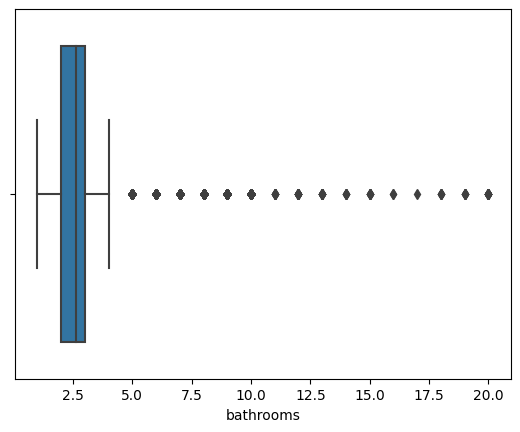

In [44]:
sns.boxplot(x = 'bathrooms', data = data)
plt.show()

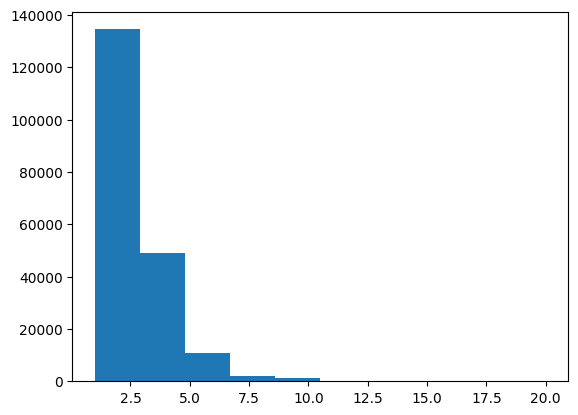

In [45]:
plt.hist(data['bathrooms']) 
plt.show()

In [46]:
# Eliminamos outliers simplificando el modelo, tomando como cantidad máxima 10 baños.
# todas las propiedades que tuvieran más de 10 baños, le imputo 10 baños.
# son 6 veces sigma

In [47]:
def outliers_bathrooms (data):
    data.loc[data[data['bathrooms']>=10].index,'bathrooms']=10
    return data

In [48]:
data = outliers_bathrooms(data)

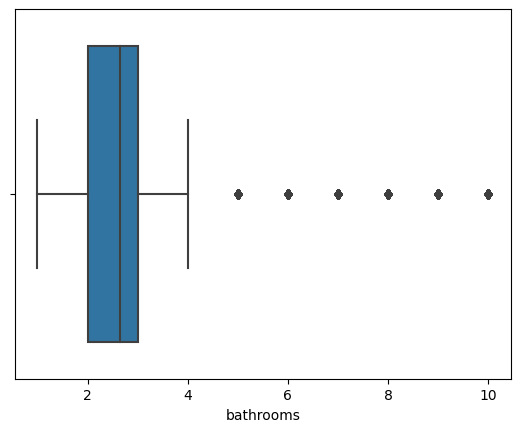

In [49]:
sns.boxplot(x = 'bathrooms', data = data)
plt.show()

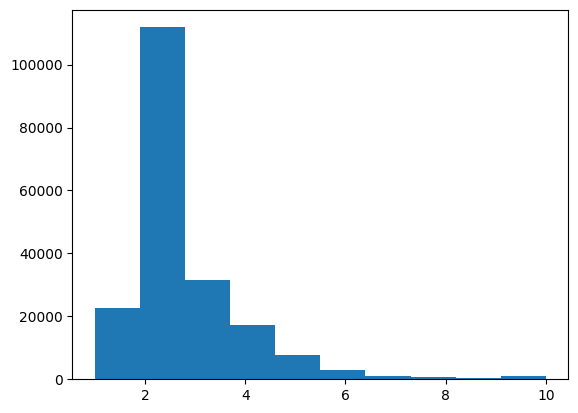

In [50]:
plt.hist(data['bathrooms']) 
plt.show()

In [51]:
# columna property_type
data['property_type'].value_counts()

Apartamento        100495
Casa                60488
Otro                16526
Lote                16501
Local comercial      1252
Finca                1134
Oficina              1080
Parqueadero            10
Name: property_type, dtype: int64

In [52]:
# Podríamos considerar como outlier al valor Parqueadero, que son sólo 10 registros.
# Para no agregar posteriormente una variable dummy adicional, vamos a imputar a esos registros el valor 'Otro'

In [53]:
def outlier_property_type (data):
    data.loc[data[data['property_type']=='Parqueadero'].index,['property_type']]='Otro'
    return data

In [54]:
data = outlier_property_type (data)

In [55]:
data['property_type'].value_counts()

Apartamento        100495
Casa                60488
Otro                16536
Lote                16501
Local comercial      1252
Finca                1134
Oficina              1080
Name: property_type, dtype: int64

In [56]:
# incorporo una columna al modelo para intentar utilizar algo de info de la columna description.
# agregamos una columna que indique la cantidad de palabras que describen la propiedad, a ver si 
# avisos más descriptivos, con mas detalle aportan información sobre el precio de la propiedad.

def col_desc_total_words (data):    
    data['desc_tot_words']=data['description'].apply(lambda x: str(x).count(' '))
    return data

In [57]:
data = col_desc_total_words (data)

In [58]:
data['desc_tot_words'].describe()

count    197486.000000
mean         61.536013
std          45.288997
min           0.000000
25%          34.000000
50%          53.000000
75%          76.000000
max        1383.000000
Name: desc_tot_words, dtype: float64

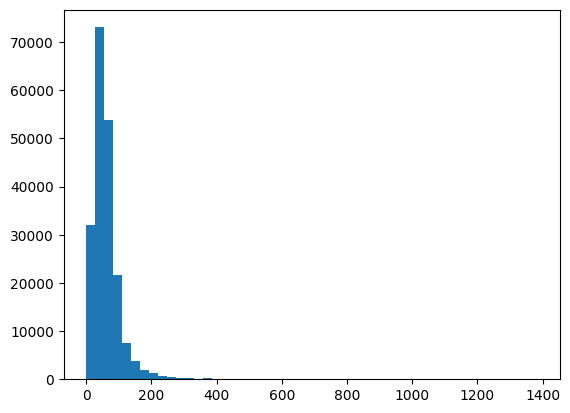

In [59]:
plt.hist(data['desc_tot_words'], bins =50) 
plt.show()

In [60]:
# trunco en 400 palabras

def truncar_cant_words(x):
    if x < 400:
        return x
    else:
        return 300


In [61]:
data['desc_tot_words']=data['desc_tot_words'].apply(truncar_cant_words)

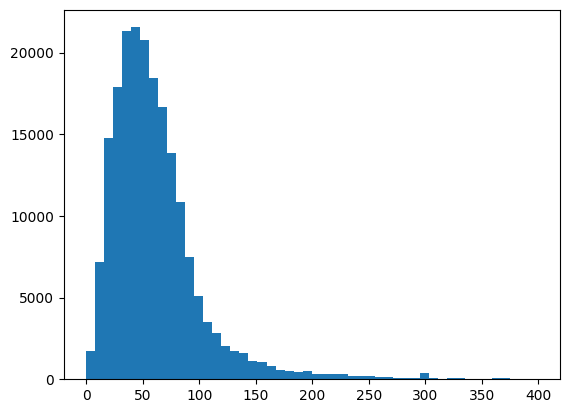

In [62]:
plt.hist(data['desc_tot_words'], bins =50) 
plt.show()

In [63]:
#agrego la columna 'target' con de acuerdo a la consigna.

def caro_barato(x):
    if x > media_precio_orig:
        return 1
    else:
        return 0

data['caro'] = data['price'].apply(lambda x: caro_barato(x))

In [64]:
data['caro'].describe()

count    197486.000000
mean          0.234741
std           0.423838
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: caro, dtype: float64

## Selección Features 1

In [65]:
#    # Quito columnas que no formarán parte del modelo
#
#   COLUMNA                 |       MOTIVO
# --------------------------+-----------------------------------------------------------
#   Unnamed: 0              |       (no agrega información para predecir, es un indice)              
#   id                      |       (no agrega información para predecir, es un indice)
#   ad_type                 |       (no aporta informacion, todo el mismo valor)
#   start_date              |       (no agrega información para predecir, es una fecha)
#   end_date                |       (no agrega información para predecir, es una fecha)
#   created_on              |       (no agrega información para predecir, es una fecha)
#   lat                     |       SE CONSIDERA
#   lon                     |       SE CONSIDERA
#   l1                      |       (info contenida en lat y long, ademas es monovalor)
#   l2                      |       (info contenida en lat y long)
#   l3                      |       (info contenida en lat y long)
#   l4                      |       (info contenida en lat y long)
#   l5                      |       (info contenida en lat y long)
#   l6                      |       (info contenida en lat y long)
#   rooms                   |       (descartar, muchos nulos) 
#   bedrooms                |       (descartar, muchos nulos)
#   bathrooms               |       SE CONSIDERA
#   surface_total           |       (descartar, muchos nulos)
#   surface_covered         |       (descartar, muchos nulos)
#   price                   |       (De acá se genera la variable target)
#   currency                |       (no aporta informacion, todo el mismo valor)
#   price_period            |       (muchos nulos, y monovalor que no tiene sentido al ser una operacion de venta)
#   title                   |       (por ahora no extraemos info de la misma)
#   description             |       (no se considera directamente, se representa con la info extraida en col desc_tot_words)
#   property_type           |       SE CONSIDERA
#   operation_type          |       (no aporta informacion, todo el mismo valor)
#   geometry                |       (info contenida en lat y long)
#   desc_tot_words          |       SE CONSIDERA
#   caro                    |       VAR target s/consigna (1 = caro / 0 = barato)        

# reservo a \data\, para avanzar con la incorporación de otras columnas al modelo quizás más adelante.
# avanzo con \data_model\ para evaluar las variables y comenzar a armar modelos

columnas = ['lat', 'lon', 'bathrooms', 'property_type',
 'desc_tot_words', 'price', 'caro']
data_model=pd.DataFrame()
data_model=data[columnas]    


In [66]:

data_model.head()

,lat,lon,bathrooms,property_type,desc_tot_words,price,caro
0,6.203000,-75.572000,4.0,Casa,168,9.000000e+09,1
1,4.722748,-74.073115,2.0,Apartamento,72,6.250000e+08,0
2,4.709000,-74.030000,2.0,Casa,72,4.200000e+08,0
3,7.117263,-73.115667,1.0,Otro,100,1.310000e+09,1
4,6.244338,-75.573553,2.0,Apartamento,57,2.100000e+08,0


In [67]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197486 entries, 0 to 197485
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   lat             197486 non-null  float64
 1   lon             197486 non-null  float64
 2   bathrooms       197486 non-null  float64
 3   property_type   197486 non-null  object 
 4   desc_tot_words  197486 non-null  int64  
 5   price           197486 non-null  float64
 6   caro            197486 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 10.5+ MB


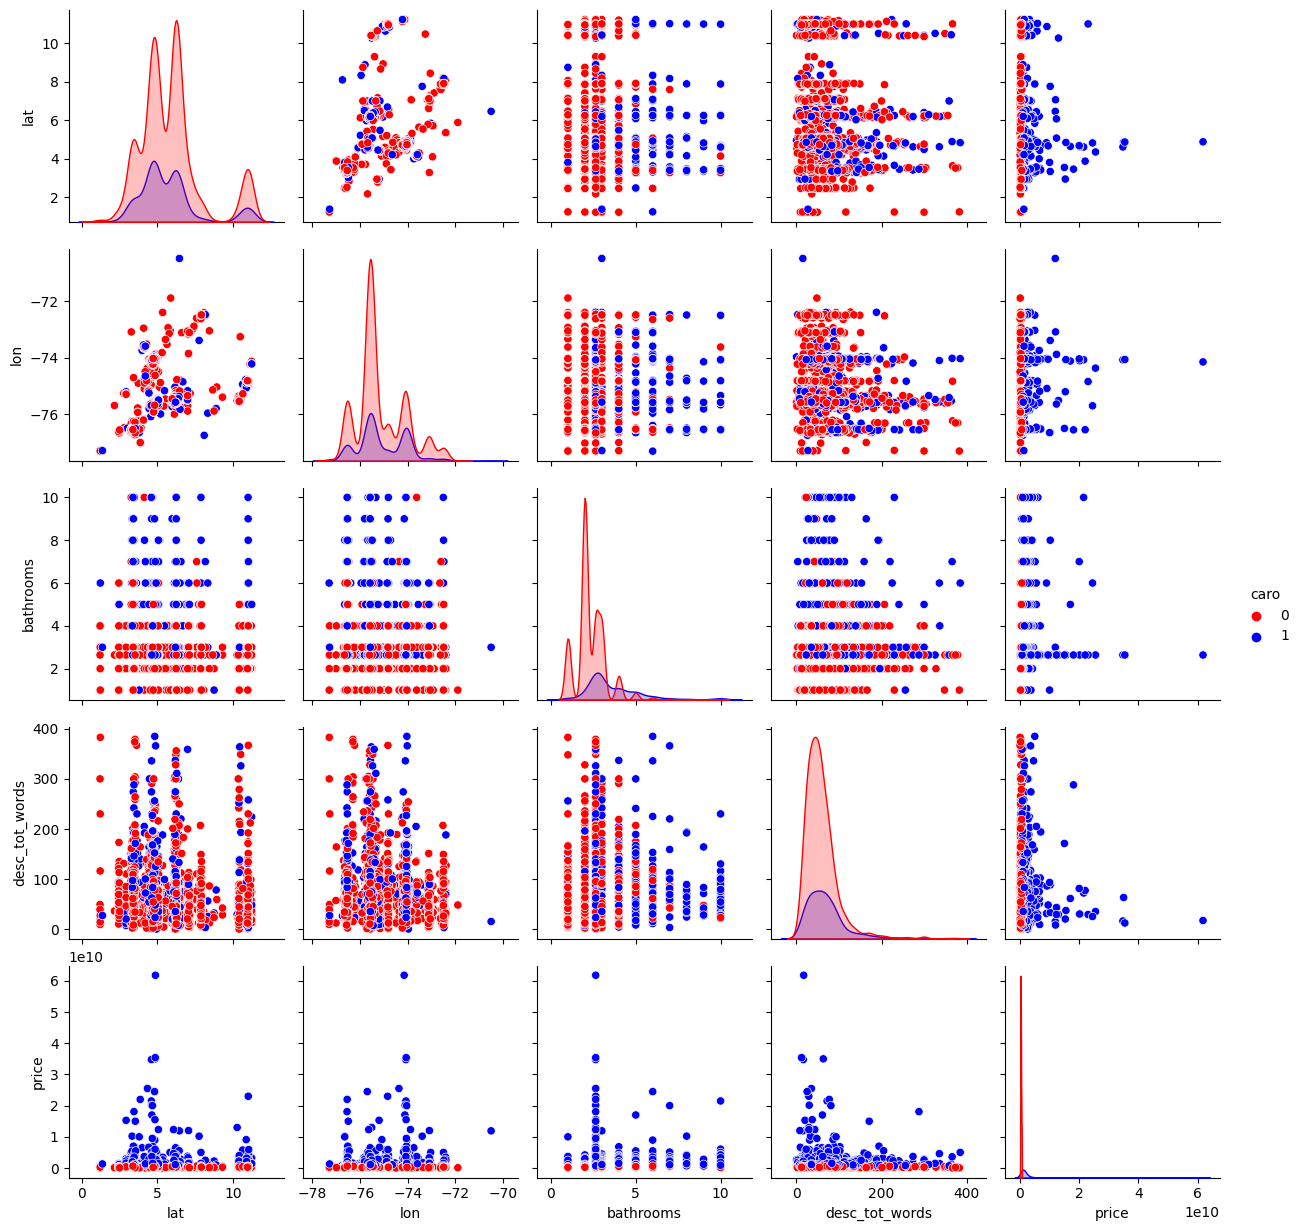

In [68]:
sns.pairplot(data_model.sample(5000), hue="caro", palette = ['r', 'b'])
plt.show()

## Escalado / Normalización

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro
count,197486.000000,197486.000000,197486.000000,197486.000000,1.974860e+05,197486.000000
mean,5.819974,-75.113818,2.637229,61.192105,6.436051e+08,0.234741
std,2.085907,1.025720,1.262198,42.246073,1.944868e+09,0.423838
min,-4.212921,-81.728390,1.000000,0.000000,0.000000e+00,0.000000
25%,4.648000,-75.596795,2.000000,34.000000,2.000000e+08,0.000000
50%,5.075436,-75.525502,2.639279,53.000000,3.300000e+08,0.000000
75%,6.244338,-74.150000,3.000000,76.000000,6.000000e+08,0.000000
max,13.351917,-67.482570,10.000000,399.000000,3.450000e+11,1.000000


In [71]:
data_model.describe()
scaler_lat = StandardScaler()
scaler_lon = StandardScaler()
scaler_bath = StandardScaler()
scaler_desc_words = StandardScaler()


scaler_lat.fit(data_model[['lat']])
scaler_lon.fit(data_model[['lon']])
scaler_bath.fit(data_model[['bathrooms']])
scaler_desc_words.fit(data_model[['desc_tot_words']])


data_model['lat'] = scaler_lat.transform(data_model[['lat']])
data_model['lon'] = scaler_lon.transform(data_model[['lon']])
data_model['bathrooms'] = scaler_bath.transform(data_model[['bathrooms']])
data_model['desc_tot_words'] = scaler_desc_words.transform(data_model[['desc_tot_words']])


C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\737995848.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lat'] = scaler_lat.transform(data_model[['lat']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\737995848.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lon'] = scaler_lon.transform(data_model[['lon']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\737995848.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [72]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro
count,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,197486.000000
mean,1.707942e-16,-3.294238e-15,8.829344e-17,-1.487748e-17,6.436051e+08,0.234741
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.944868e+09,0.423838
min,-4.809861e+00,-6.448730e+00,-1.297129e+00,-1.448472e+00,0.000000e+00,0.000000
25%,-5.618548e-01,-4.708680e-01,-5.048581e-01,-6.436616e-01,2.000000e+08,0.000000
50%,-3.569381e-01,-4.013624e-01,1.623469e-03,-1.939145e-01,3.300000e+08,0.000000
75%,2.034442e-01,9.396527e-01,2.874124e-01,3.505162e-01,6.000000e+08,0.000000
max,3.610882e+00,7.439916e+00,5.833307e+00,7.996217e+00,3.450000e+11,1.000000


## Codificación de Variables CAT

In [73]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197486 entries, 0 to 197485
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   lat             197486 non-null  float64
 1   lon             197486 non-null  float64
 2   bathrooms       197486 non-null  float64
 3   property_type   197486 non-null  object 
 4   desc_tot_words  197486 non-null  float64
 5   price           197486 non-null  float64
 6   caro            197486 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.5+ MB


In [74]:
cols_ohe=list(data_model['property_type'].value_counts().index)
def onehot_property_type(data_model, cols_ohe):
    ''' cols_ohe tienen que ser la lista de columnas columnas del dataframe original, asi codifica igual en otro subset'''
    
    # agrego las columnas todas en 0
    data_model[cols_ohe]=0 

    # pongo un 1 en las posiciones que coincida el valor del registro property_type con el nombre de la col en cuestion
    for columna in cols_ohe:    
        data_model.loc[data_model[data_model['property_type']==columna].index,[columna]]=1
    return data_model



In [75]:
data_model = onehot_property_type(data_model, cols_ohe)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [76]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro,Apartamento,Casa,Otro,Lote,Local comercial,Finca,Oficina
count,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,197486.000000,197486.000000,197486.000000,197486.000000,197486.000000,197486.00000,197486.000000,197486.000000
mean,1.707942e-16,-3.294238e-15,8.829344e-17,-1.487748e-17,6.436051e+08,0.234741,0.508872,0.306290,0.083733,0.083555,0.00634,0.005742,0.005469
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.944868e+09,0.423838,0.499923,0.460953,0.276987,0.276720,0.07937,0.075559,0.073749
min,-4.809861e+00,-6.448730e+00,-1.297129e+00,-1.448472e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-5.618548e-01,-4.708680e-01,-5.048581e-01,-6.436616e-01,2.000000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,-3.569381e-01,-4.013624e-01,1.623469e-03,-1.939145e-01,3.300000e+08,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,2.034442e-01,9.396527e-01,2.874124e-01,3.505162e-01,6.000000e+08,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,3.610882e+00,7.439916e+00,5.833307e+00,7.996217e+00,3.450000e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [77]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro,Apartamento,Casa,Otro,Lote,Local comercial,Finca,Oficina
count,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,197486.000000,197486.000000,197486.000000,197486.000000,197486.000000,197486.00000,197486.000000,197486.000000
mean,1.707942e-16,-3.294238e-15,8.829344e-17,-1.487748e-17,6.436051e+08,0.234741,0.508872,0.306290,0.083733,0.083555,0.00634,0.005742,0.005469
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.944868e+09,0.423838,0.499923,0.460953,0.276987,0.276720,0.07937,0.075559,0.073749
min,-4.809861e+00,-6.448730e+00,-1.297129e+00,-1.448472e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-5.618548e-01,-4.708680e-01,-5.048581e-01,-6.436616e-01,2.000000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,-3.569381e-01,-4.013624e-01,1.623469e-03,-1.939145e-01,3.300000e+08,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,2.034442e-01,9.396527e-01,2.874124e-01,3.505162e-01,6.000000e+08,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,3.610882e+00,7.439916e+00,5.833307e+00,7.996217e+00,3.450000e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [78]:
# from sklearn.preprocessing import OneHotEncoder

In [79]:
#data_encoded = data_model[['property_type']]
#ohe = OneHotEncoder(handle_unknown = 'ignore')
#data_encoded = pd.DataFrame(ohe.fit_transform(data_encoded).toarray())
#data_model = data_model.join(data_encoded)

In [80]:
data_model.isnull().sum()

lat                0
lon                0
bathrooms          0
property_type      0
desc_tot_words     0
price              0
caro               0
Apartamento        0
Casa               0
Otro               0
Lote               0
Local comercial    0
Finca              0
Oficina            0
dtype: int64

In [81]:
# data_model.to_csv('df_train.csv')

## --------------------------------------------------------------------

## Procesamiento LN

In [83]:
import nltk
from nltk.tokenize import word_tokenize



En este apartado, obtendremos una lista con todas las palabras empleadas en la descripcion de los avisos. Posteriormente clasificaremos esas palabras en cuanto a su frecuencia de aparicion en las 2 clases (caro/barato) para observar si podemos asociar el uso de algunas a la clase a predecir.

In [1]:
# Armo una variable 'string' que contenga toooodas las palabras de la columna 'description'
lista_description = list(data['description'].astype(str))
string = ' '.join(lista_description)
# convierto a minúsculas
string = string.lower() 
# quito caracteres especiales
string_sin_especiales = re.sub(r'\W+', ' ', string)
lista_strings = string_sin_especiales.split(' ')


NameError: name 'data' is not defined

In [89]:
def unique(list1):
    '''Esta función genera una lista de elementos únicos'''
    # initialize a null list
    unique_list = []
  
    # traverse for all elements
    for j,x in enumerate(list1):
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
        if j % 1000000 == 0:
            print(round(j/len(list1)*100,2),'%')
    return unique_list


In [ ]:

lista_strings_unicos = unique(lista_strings)

#tarda 9 min

In [ ]:
stopwords = nltk.corpus.stopwords.words('spanish')
lista_unicos_sinsw = [word for word in lista_strings_unicos if word not in stopwords] #quito las 'stopwords'
lista_unicos_sinsw.sort() #ordeno

def quitar_numericos (lista_orig):
    ''' Esta funcion quita de la lista los elementos que tengan números'''
    for j,i in enumerate(lista_orig):
        x = re.findall('\d', i)
        if x:
            lista_orig.pop(j)
        
    return lista_orig

# ejecuto la función para limpiar la lista
lista_limpia = quitar_numericos(lista_unicos_sinsw)
# esta es la lista input de palabras

In [ ]:
lista_limpia = []

for i in range(0,len(lista_unicos_sinsw)):
    x = re.findall('\d', lista_unicos_sinsw[i])
    if x:
        pass
    else:
        lista_limpia.append(lista_unicos_sinsw[i])

In [ ]:
lista_limpia

['',
 '_',
 '___',
 '____',
 '________________________________________________________',
 '____________________________________________________________________',
 '___desarrollada',
 '__si_',
 '_a',
 '_acogedor',
 '_acogedora',
 '_acá',
 '_adicional',
 '_administración',
 '_adultos',
 '_aestrato',
 '_aexcelente',
 '_agradable',
 '_agua',
 '_alacena',
 '_alacenasalon',
 '_alamedadescripción',
 '_alcoba',
 '_alfombra',
 '_alquiler',
 '_altos',
 '_amplia',
 '_amplias',
 '_amplio',
 '_apartaestudio',
 '_apartaestudio_',
 '_apartamento',
 '_apartamentopara',
 '_aprovecha',
 '_aproveche',
 '_apto',
 '_aqui',
 '_aquí',
 '_aranjuez',
 '_archivos',
 '_area',
 '_aria',
 '_arrienda',
 '_arriendo',
 '_arto',
 '_ascensor',
 '_asesor',
 '_ax',
 '_balcon',
 '_balcón',
 '_bar',
 '_baã',
 '_baño',
 '_baños',
 '_bañosala',
 '_belisario',
 '_bella',
 '_bellisímo',
 '_bellísima',
 '_bellísimo',
 '_biblioteca',
 '_bisein',
 '_bit',
 '_blancadescripción',
 '_blindaje',
 '_bodega',
 '_bog',
 '_bogotá',
 '_bo

In [ ]:
# quito espacios vacíos de cada string del ppo y del final
for i in range(0,len(lista_limpia)):
    lista_limpia[i]=lista_limpia[i].strip()
    lista_limpia[i]=lista_limpia[i].strip('_') 
    lista_limpia[i]=lista_limpia[i].strip('-')


In [ ]:
lista_limpia.sort()

In [ ]:
lista_limpia

['',
 '',
 '',
 '',
 '',
 '',
 'a',
 'aa',
 'aaa',
 'aaatiene',
 'aabados',
 'aacc',
 'aacensor',
 'aacute',
 'aadmon',
 'aalquilaría',
 'aantejardin',
 'aapartamento',
 'aaprtamento',
 'aapto',
 'aarea',
 'aartamento',
 'aas',
 'aatendemos',
 'aaval',
 'aavt',
 'ab',
 'abacados',
 'abad',
 'abada',
 'abadia',
 'abadias',
 'abados',
 'abadía',
 'abadías',
 'abajam',
 'abajamesta',
 'abajito',
 'abajo',
 'abajorecibo',
 'abana',
 'abandonada',
 'abandono',
 'abanico',
 'abanicos',
 'abarca',
 'abarcando',
 'abarcar',
 'abarco',
 'abarcó',
 'abarrotes',
 'abastece',
 'abastecedores',
 'abastecen',
 'abastecer',
 'abastecerse',
 'abastecerá',
 'abastecida',
 'abastecimiento',
 'abastecimientocod',
 'abastecimientos',
 'abastecían',
 'abasto',
 'abastos',
 'abatible',
 'abatibles',
 'abayan',
 'abaño',
 'abba',
 'abbas',
 'abcinmobi',
 'abcinmobiliaria',
 'abcinmuebles',
 'abedul',
 'abedules',
 'abejas',
 'abejorra',
 'abejorral',
 'abelardo',
 'abello',
 'aberdeen',
 'aberta',
 'abertura

In [ ]:

# Eliminamos las palabras de menos de 3 letras    
lista_limpia = [word for word in lista_limpia if len(word)>3] 

In [ ]:
listadf=pd.DataFrame()
listadf['palabra']=lista_limpia

In [ ]:
listadf['frec']=listadf['palabra'].apply(lambda x: string_sin_especiales.count(x))

# 65 minutos

In [ ]:
listadf_sorted = listadf.sort_values(by= 'frec', ascending=False)

In [ ]:
listadf_sorted.reset_index()

,index,palabra,frec
0,5824,baño,209243
1,5825,baño,209243
2,9934,cina,207049
3,17343,enta,195032
4,46580,zona,177397
...,...,...,...
46866,18647,etnoturísticos,1
46867,18646,ethernet,1
46868,36910,reconociendo,1
46869,18641,etcte,1


In [ ]:
listadf_sorted=listadf_sorted.reset_index()

In [ ]:
listadf_sorted.drop('index', inplace=True, axis=1)

In [ ]:
listadf_sorted

,palabra,frec
0,baño,209243
1,baño,209243
2,cina,207049
3,enta,195032
4,zona,177397
...,...,...
46866,etnoturísticos,1
46867,ethernet,1
46868,reconociendo,1
46869,etcte,1


In [ ]:
# quiero que aparezcan en al menos en proporcion a un 5% de las filas para que pueda servir para algo.
# En realidad lo haría para todas, pero tarda muchisimo. Debemos hacer este recorte para poder avanzar.
listadf_final=listadf_sorted[listadf_sorted['frec']>len(data)*0.05]

In [ ]:
len(listadf_final)

822

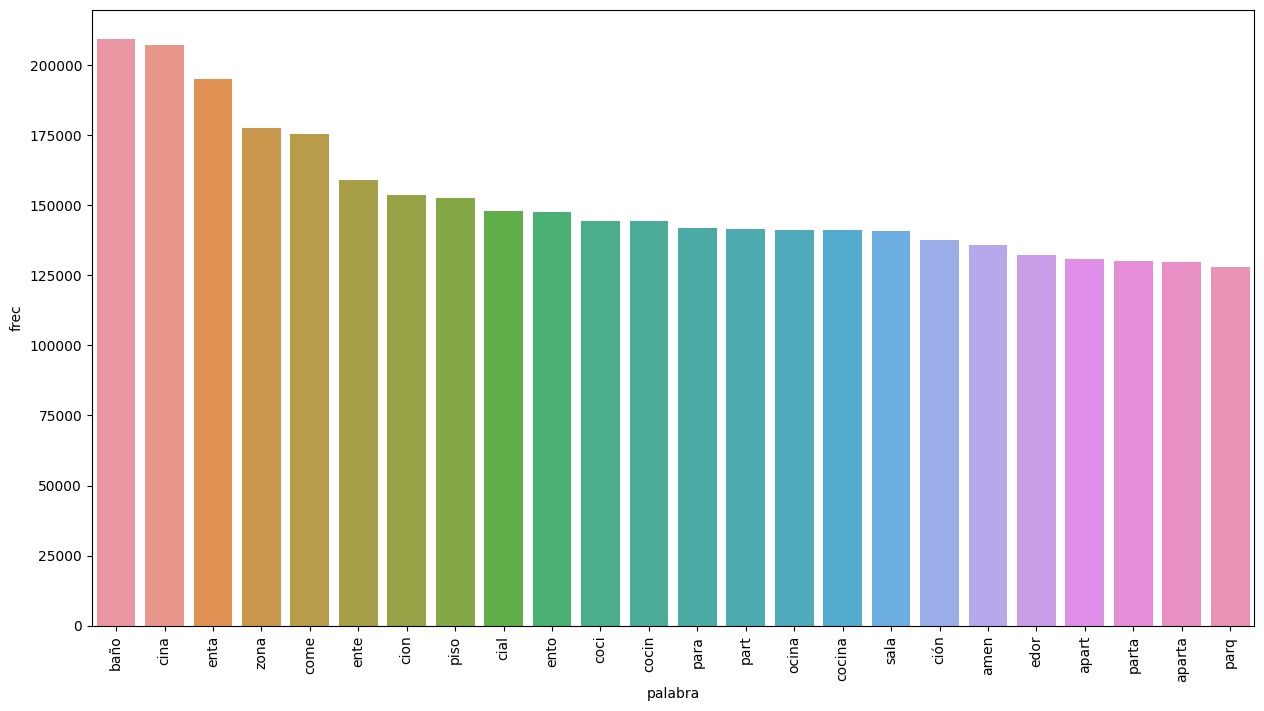

In [ ]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = listadf_sorted.loc[:30,'palabra'], y = listadf_sorted.loc[:30,'frec'])
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [ ]:
lista_final = list(listadf_final['palabra'].astype(str))

In [ ]:
def sumar_palabras(lista, data):
    ''' 
    Esta funcion recibe 2 inputs.
    Una lista con las palabras a verificar; y
    el dataframe contra el cual hay que hacer el chequeo en la col ['description'] 
    '''

    #Creo 1 dataframe con la lista de palabras 
    data_palab=pd.DataFrame()
    data_palab['palabra']=lista
    data_palab['palab_caro'] = 0
    data_palab['palab_barato']= 0

    # compruebo si la palabra está en la descripcion del aviso y la calsifico en la col caro o barato según
    # la haya encontrado en un aviso correspondiente a la clasificación de caro o barato.
    for i,palab in enumerate(data_palab['palabra']):
        aux_caro=0
        aux_barato=0
        for k in range(0,len(data)):
            if palab in (str(data.loc[k,'description'])).lower():
                if data.loc[k,'caro']==1:
                    aux_caro+=1
                else:
                    aux_barato+=1
            else:
                pass
        data_palab.loc[i,'palab_caro'] = aux_caro
        data_palab.loc[i,'palab_barato'] = aux_barato
        if (i+1)%10 == 0:
            print(i+1,'/',len(data_palab['palabra']))
    
    cant_avisos_caros = data['caro'].sum() # cantidad de registros de avisos clasificados como caros
    cant_avisos_baratos = len(data)-cant_avisos_caros # cantidad de registros de avisos clasificados como caros

    data_palab['palab_caro']=data_palab['palab_caro']/cant_avisos_caros
    data_palab['palab_barato']=data_palab['palab_barato']/cant_avisos_baratos
    

    return data_palab



In [ ]:

dfpalab = sumar_palabras(lista_final, data)
dfpalab

10 / 822
20 / 822
30 / 822
40 / 822
50 / 822
60 / 822
70 / 822
80 / 822
90 / 822
100 / 822
110 / 822
120 / 822
130 / 822
140 / 822
150 / 822
160 / 822
170 / 822
180 / 822
190 / 822
200 / 822
210 / 822
220 / 822
230 / 822
240 / 822
250 / 822
260 / 822
270 / 822
280 / 822
290 / 822
300 / 822
310 / 822
320 / 822
330 / 822
340 / 822
350 / 822
360 / 822
370 / 822
380 / 822
390 / 822
400 / 822
410 / 822
420 / 822
430 / 822
440 / 822
450 / 822
460 / 822
470 / 822
480 / 822
490 / 822
500 / 822
510 / 822
520 / 822
530 / 822
540 / 822
550 / 822
560 / 822
570 / 822
580 / 822
590 / 822
600 / 822
610 / 822
620 / 822
630 / 822
640 / 822
650 / 822
660 / 822
670 / 822
680 / 822
690 / 822
700 / 822
710 / 822
720 / 822
730 / 822
740 / 822
750 / 822
760 / 822
770 / 822
780 / 822
790 / 822
800 / 822
810 / 822
820 / 822


,palabra,palab_caro,palab_barato
0,baño,0.574421,0.694689
1,baño,0.574421,0.694689
2,cina,0.636589,0.755393
3,enta,0.601708,0.603429
4,zona,0.517710,0.563258
...,...,...,...
817,tren,0.027460,0.054550
818,dultos,0.028194,0.055926
819,adultos,0.028172,0.055880
820,adultos,0.028172,0.055880


In [ ]:
# la idea fue obtener para cada palabra, en qué proporción aparecen en los avisos de la clase 1 y de la clase 0.
# tenemos 2 columnas, palab_caro que indica cuantas veces aparece dicha palabra en relacion a la cantidad de avisos de esa categoria.
# lo mismo para la otra columna barato.

In [ ]:
dfpalab['prob_caro'] = dfpalab['palab_caro'] / (dfpalab['palab_caro'] + dfpalab['palab_barato'])
dfpalab['prob_barato'] = dfpalab['palab_barato'] / (dfpalab['palab_caro'] + dfpalab['palab_barato'])
# calculo la probabilidad de que la palabara aparezca en una clase o en la otra y la agrego a mi matriz.

In [ ]:
dfpalab.sort_values('prob_barato', ascending=True).head(50)

,palabra,palab_caro,palab_barato,prob_caro,prob_barato
684,finca,0.088032,0.024383,0.783097,0.216903
683,finca,0.088032,0.024383,0.783097,0.216903
675,inca,0.088507,0.024926,0.780258,0.219742
776,jacuzz,0.109302,0.034104,0.762187,0.237813
773,jacuz,0.110445,0.034527,0.761836,0.238164
789,jacuzzi,0.106454,0.033568,0.760269,0.239731
786,acuzzi,0.106842,0.033707,0.760179,0.239821
637,oficina,0.102593,0.034401,0.748885,0.251115
638,oficina,0.102593,0.034401,0.748885,0.251115
636,ficina,0.102593,0.034408,0.748849,0.251151


In [ ]:
# guardamos x las dudas el archivo
dfpalab.to_csv('dfpalab.csv', index=False)

In [84]:
#levanto el archivo y sigo desde acá
dfpalab=pd.read_csv('dfpalab.csv')

In [85]:
# extraigo las palabras que tienen una probabilidad +72% de estar presentes en avisos 'caros'
palabras_caras = list(dfpalab['palabra'][dfpalab['prob_caro']>0.72])

In [86]:
len(palabras_caras)

21

In [90]:
palabras_caras
palabras_caras = unique(palabras_caras)

0.0 %


In [91]:
#bueno, finalmente tengo una lista de palabras asociadas a avisos caros
palabras_caras

['lote',
 'construid',
 'ficina',
 'oficina',
 'imen',
 'inca',
 'finca',
 'fruta',
 'jacuz',
 'jacuzz',
 'ruida',
 'acuzzi',
 'construida',
 'jacuzzi',
 'dientes',
 'pendientes',
 'dependientes',
 'independientes']

In [ ]:
#pensé que iba a poder obtener más palabras

In [92]:
def feature_palabras_caras(lista_palabras, data):
    ''' 
    Esta funcion recibe 2 inputs.
    Una lista con las palabras a verificar; y
    el dataframe contra el cual hay que comparar, en la col ['description'] 
    '''

    # Agrego col de ceros en data 
    data['palab_cara']=0

    # para cada palabra en la lista compruebo si la palabra está en la descripcion del aviso y 
    # coloco el 1 correspondiente en la nueva columna.
    
    
    for k in range(0,len(data)):
        for i in range(0,len(lista_palabras)):
            if lista_palabras[i] in (str(data.loc[k,'description'])).lower():
                data.loc[k, 'palab_cara'] = 1
                break
            else:
                pass
        if (k+1)%10 == 0:
            print(k+1,'/',len(data))
      

    return data


# Esta funcion compara la palabra con cada una de las descripciones. y coloca un 1 en la nueva columnas para todos los
# registros en los que aparece en la descripcion, indicando con mucha seguridad que se trata de avisos caros.


In [93]:
#agregamos la columna a nuestro dataset de trabajo
data = feature_palabras_caras(palabras_caras,data)
# 1min

10 / 197486
20 / 197486
30 / 197486
40 / 197486
50 / 197486
60 / 197486
70 / 197486
80 / 197486
90 / 197486
100 / 197486
110 / 197486
120 / 197486
130 / 197486
140 / 197486
150 / 197486
160 / 197486
170 / 197486
180 / 197486
190 / 197486
200 / 197486
210 / 197486
220 / 197486
230 / 197486
240 / 197486
250 / 197486
260 / 197486
270 / 197486
280 / 197486
290 / 197486
300 / 197486
310 / 197486
320 / 197486
330 / 197486
340 / 197486
350 / 197486
360 / 197486
370 / 197486
380 / 197486
390 / 197486
400 / 197486
410 / 197486
420 / 197486
430 / 197486
440 / 197486
450 / 197486
460 / 197486
470 / 197486
480 / 197486
490 / 197486
500 / 197486
510 / 197486
520 / 197486
530 / 197486
540 / 197486
550 / 197486
560 / 197486
570 / 197486
580 / 197486
590 / 197486
600 / 197486
610 / 197486
620 / 197486
630 / 197486
640 / 197486
650 / 197486
660 / 197486
670 / 197486
680 / 197486
690 / 197486
700 / 197486
710 / 197486
720 / 197486
730 / 197486
740 / 197486
750 / 197486
760 / 197486
770 / 197486
780 / 19

In [94]:
# vemos que la correlación con la variable objetivo no es muy buena, 
# pero la vamos a incorporar de todos modos al modelo para probar si mejora
data['palab_cara'].corr(data['caro'], method='pearson')

0.3153382095321758

In [95]:
# Agrego también la columna a mi data_model
data_model['palab_cara'] = data['palab_cara']

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\4139327768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['palab_cara'] = data['palab_cara']


### Vamos a intentar inferir de la descripcion la cantidad de habitaciones usando regex
De esa manera agregaremos una variable más al modelo que puede ser importante.
Inferiremos la cantidad de habitaciones, y la superficie de cada propiedad ofrecida.

In [ ]:
#comencemos por normalizar la columna 'description'

In [96]:
def conv_num_texto(x):
    ''' Esta funcion convierte numeros del uno al diez en texto
        por sus respectivos números'''
    #definimos la matriz de transformación
    mat = [ [' un ',' 1 '],
            [' una ',' 1 '],
            [' uno ',' 1 '],
            ['dos','2'],
            ['tres','3'],
            ['cuatro','4'],
            ['cinco','5'],
            ['seis','6'],
            ['siete','7'],
            ['ocho','8'],
            ['nueve','9'],
            ['diez','10']]
            
    a = str(x).lower()        
    for i in range(0,len(mat)): 
        a = a.replace(mat[i][0],mat[i][1])
        #a = a.replace(mat[6][0],mat[6][1])
    
    return a


In [97]:
#realizo las transformaciones en una copia del df asi no afecto el dato original
data2=data.copy()

In [98]:
data2['description']=data2['description'].apply(lambda x: conv_num_texto(x))

In [99]:
def extraer_num_habit(x):
    a = re.search('\d+ ?habit', str(x).lower())
    if a:
        y = re.findall('\d+',a.group())
        return int(y[0])
    else:
        a = re.search('\d+ ?alc', str(x).lower())
        if a:
            y = re.findall('\d+',a.group())
            return int(y[0])
        else:
            a = re.search('\d+ ?dormit', str(x).lower())
            if a:
                y = re.findall('\d+',a.group())
                return int(y[0])
            else:    
                return np.NaN

In [100]:
data2['habit_desc']=np.NaN
data2['habit_desc']=data2['description'].apply(lambda x: extraer_num_habit(x))

In [101]:
data2['habit_desc'].isnull().sum()/len(data)
# excelente, logramos recuperar casi un 70% de la información

0.33939621036427897

In [102]:
#Ahora sí paso la columna al df que veníamos trabajando
data['habit_desc'] = data2['habit_desc'] 

In [103]:
# generamos nuevamente la copia del df
data2=data.copy()

In [104]:
data2['sup_desc']= np.NaN

In [105]:
# repetimos lo propio ahora con la superficie
def extraer_superficie(x):
    a = re.search('(\d+ ?m2)|(\d+ ?mt2)|(\d+ ?mts)|(\d+ ?metr)', str(x).lower())
    if a:
        y = re.findall('\d+',a.group())
        return int(y[0])
    else:
        return np.NaN

In [106]:
data2['sup_desc']=data2['description'].apply(lambda x: extraer_superficie(x))

In [107]:
data2['sup_desc'].isnull().sum()/len(data)
#logramos apenas el 35% de la información. Es muy poco. No avanzamos con esta columna

0.6396605328985345

In [108]:
# Lleno los datos de 'bedrooms' con la nueva columna;
# despues vemos como imputamos el resto de los nulos, y corregimos OUTLIERS
data2['bedrooms'].fillna(value=data['habit_desc'], inplace=True)



In [109]:
data2['bedrooms'].isnull().sum()/len(data)
# 73% de valores recuperados !!!

0.2786070911355742

In [110]:
mediana_bedrooms = data2['bedrooms'].median()

In [111]:
data2['bedrooms'].fillna(value=mediana_bedrooms, inplace=True)

In [112]:
data2['bedrooms'].isnull().sum()

0

In [113]:
data['bedrooms'] = data2['bedrooms']

In [114]:
data['bedrooms'].quantile(0.9975)

20.0

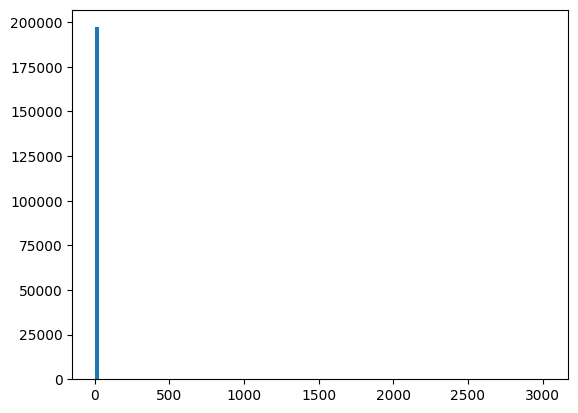

In [115]:
plt.hist(data['bedrooms'], bins=100) 
plt.show()

In [ ]:
# hay muy poquitos valores totalmente alejados, fijemonos que el cuantil 99,75% es 20. 
# Asignaemos a todos los valores mayores a 20, el valor de la mediana, que es 3.

In [116]:
data.loc[data[data['bedrooms']>20].index,'bedrooms'] = mediana_bedrooms

In [117]:
data['bedrooms'].describe()

count    197486.000000
mean          3.031400
std           1.123564
min           0.000000
25%           3.000000
50%           3.000000
75%           3.000000
max          20.000000
Name: bedrooms, dtype: float64

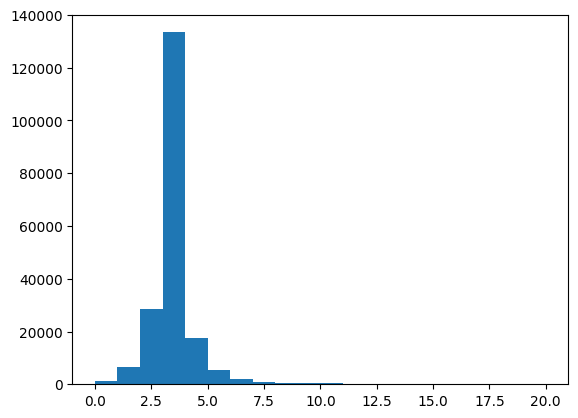

In [118]:
plt.hist(data['bedrooms'], bins=20) 
plt.show()

In [119]:
# creo una función que me permita hacer todas las transformaciones aplicadas a
# esta nueva columna 'bedrooms', para aplicarla luego al set de test.

def bedrooms(data):
    data2=data.copy()
    data2['description']=data2['description'].apply(lambda x: conv_num_texto(x))
    data2['habit_desc']=np.NaN
    data2['habit_desc']=data2['description'].apply(lambda x: extraer_num_habit(x))
    data['habit_desc'] = data2['habit_desc']
    data2['bedrooms'].fillna(value=data['habit_desc'], inplace=True)
    data2['bedrooms'].fillna(value=mediana_bedrooms, inplace=True)
    data['bedrooms'] = data2['bedrooms']
    data.loc[data[data['bedrooms']>20].index,'bedrooms'] = mediana_bedrooms
    return data
    

In [120]:
# agreguemos el feature a nuestro data_model y escalemos
data_model['bedrooms'] = data['bedrooms']

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3424608786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['bedrooms'] = data['bedrooms']


In [121]:
# avancemos con el escalado
scaler_bedrooms = StandardScaler()
scaler_bedrooms.fit(data_model[['bedrooms']])
data_model['bedrooms'] = scaler_bedrooms.transform(data_model[['bedrooms']])



C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\554935574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['bedrooms'] = scaler_bedrooms.transform(data_model[['bedrooms']])


## -----------------------------------------------------------------------

## Pasos a aplicar a dataset test antes de hacer predict

In [122]:
#abro la data del test
data_test = pd.read_csv('../properties_colombia_test.csv')


In [123]:
# hago las mismas transoformaciones, rellenado de nulos, etc. (excepto la quita de valores)

def transform_test(data):
    data = llenar_latitud(data)
    data = llenar_longitud(data)
    data = llenar_bathrooms (data)
    data = outliers_bathrooms(data)
    data = outlier_property_type(data)
    data = col_desc_total_words(data)
    data['desc_tot_words']=data['desc_tot_words'].apply(truncar_cant_words)
    data = feature_palabras_caras(palabras_caras, data)

    # ultima columna de bedrooms
    data = bedrooms(data)


    return data



data_test = transform_test(data_test)

# Demora aprox 5 min, 30 seg

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3601405961.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3601405961.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers


10 / 65850
20 / 65850
30 / 65850
40 / 65850
50 / 65850
60 / 65850
70 / 65850
80 / 65850
90 / 65850
100 / 65850
110 / 65850
120 / 65850
130 / 65850
140 / 65850
150 / 65850
160 / 65850
170 / 65850
180 / 65850
190 / 65850
200 / 65850
210 / 65850
220 / 65850
230 / 65850
240 / 65850
250 / 65850
260 / 65850
270 / 65850
280 / 65850
290 / 65850
300 / 65850
310 / 65850
320 / 65850
330 / 65850
340 / 65850
350 / 65850
360 / 65850
370 / 65850
380 / 65850
390 / 65850
400 / 65850
410 / 65850
420 / 65850
430 / 65850
440 / 65850
450 / 65850
460 / 65850
470 / 65850
480 / 65850
490 / 65850
500 / 65850
510 / 65850
520 / 65850
530 / 65850
540 / 65850
550 / 65850
560 / 65850
570 / 65850
580 / 65850
590 / 65850
600 / 65850
610 / 65850
620 / 65850
630 / 65850
640 / 65850
650 / 65850
660 / 65850
670 / 65850
680 / 65850
690 / 65850
700 / 65850
710 / 65850
720 / 65850
730 / 65850
740 / 65850
750 / 65850
760 / 65850
770 / 65850
780 / 65850
790 / 65850
800 / 65850
810 / 65850
820 / 65850
830 / 65850
840 / 65850
8

In [124]:
data_test.isnull().sum()

Unnamed: 0             0
id                     0
ad_type                0
start_date             0
end_date               0
created_on             0
lat                    0
lon                    0
l1                     0
l2                     0
l3                     0
l4                 50776
l5                 56798
l6                 63486
rooms              56740
bedrooms               0
bathrooms              0
surface_total      63536
surface_covered    62545
currency              17
price_period       53729
title                  0
description           27
property_type          0
operation_type         0
geometry               0
desc_tot_words         0
palab_cara             0
habit_desc         22415
dtype: int64

In [125]:
# replico el uso de las columnas que componen el modelo para este subset

data_model_test = pd.DataFrame()
columnas_test = columnas = ['lat', 'lon', 'bathrooms', 'property_type','desc_tot_words']
data_model_test = data_test[columnas]

In [126]:
# agrego también las columnas resultantes del apartado PLN
columnas_PLN = ['palab_cara', 'bedrooms']
data_model_test[columnas_PLN] = data_test[columnas_PLN]

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\981478401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_test[columnas_PLN] = data_test[columnas_PLN]
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\981478401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_test[columnas_PLN] = data_test[columnas_PLN]


In [127]:
data_model_test.describe()

,lat,lon,bathrooms,desc_tot_words,palab_cara,bedrooms
count,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000
mean,5.833646,-75.115216,2.638197,60.716234,0.364009,3.024617
std,2.100318,1.024412,1.255925,41.630425,0.481155,1.105521
min,-4.212921,-81.705052,1.000000,0.000000,0.000000,0.000000
25%,4.649456,-75.596142,2.000000,34.000000,0.000000,3.000000
50%,5.077178,-75.525287,2.639624,53.000000,0.000000,3.000000
75%,6.244338,-74.150851,3.000000,75.000000,1.000000,3.000000
max,13.338761,-67.924336,10.000000,399.000000,1.000000,20.000000


In [128]:
#replico el escalado de las variables del modelo

def scale_test(data_model):
    data_model['lat'] = scaler_lat.transform(data_model[['lat']])
    data_model['lon'] = scaler_lon.transform(data_model[['lon']])
    data_model['bathrooms'] = scaler_bath.transform(data_model[['bathrooms']])
    data_model['desc_tot_words'] = scaler_desc_words.transform(data_model[['desc_tot_words']])
    data_model['bedrooms'] = scaler_bedrooms.transform(data_model[['bedrooms']])
    
    return data_model

data_model_test = scale_test(data_model_test)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\799837850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lat'] = scaler_lat.transform(data_model[['lat']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\799837850.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lon'] = scaler_lon.transform(data_model[['lon']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\799837850.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [129]:
data_model_test.describe()

,lat,lon,bathrooms,desc_tot_words,palab_cara,bedrooms
count,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000
mean,0.006555,-0.001363,0.000766,-0.011264,0.364009,-0.006037
std,1.006911,0.998728,0.995033,0.985430,0.481155,0.983944
min,-4.809861,-6.425977,-1.297129,-1.448472,0.000000,-2.698028
25%,-0.561157,-0.470232,-0.504858,-0.643662,0.000000,-0.027947
50%,-0.356103,-0.401153,0.001897,-0.193914,0.000000,-0.027947
75%,0.203444,0.938823,0.287412,0.326845,1.000000,-0.027947
max,3.604575,7.009225,5.833307,7.996217,1.000000,15.102516


In [130]:
data_model_test['property_type'].value_counts()

Apartamento        33524
Casa               20084
Lote                5704
Otro                5379
Local comercial      434
Finca                377
Oficina              348
Name: property_type, dtype: int64

In [131]:
# replico la codificacion onehot usada previamente
data_model_test = onehot_property_type(data_model_test, cols_ohe)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_3916\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [132]:
# Datos listos para pasar hacer predict
data_model_test.describe()

,lat,lon,bathrooms,desc_tot_words,palab_cara,bedrooms,Apartamento,Casa,Otro,Lote,Local comercial,Finca,Oficina
count,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000
mean,0.006555,-0.001363,0.000766,-0.011264,0.364009,-0.006037,0.509096,0.304996,0.081686,0.086621,0.006591,0.005725,0.005285
std,1.006911,0.998728,0.995033,0.985430,0.481155,0.983944,0.499921,0.460409,0.273887,0.281281,0.080916,0.075448,0.072504
min,-4.809861,-6.425977,-1.297129,-1.448472,0.000000,-2.698028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.561157,-0.470232,-0.504858,-0.643662,0.000000,-0.027947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.356103,-0.401153,0.001897,-0.193914,0.000000,-0.027947,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.203444,0.938823,0.287412,0.326845,1.000000,-0.027947,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.604575,7.009225,5.833307,7.996217,1.000000,15.102516,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [133]:
#Guardo los csv de los modelos
data_model.to_csv('df_train.csv')
data_model_test.to_csv('df_test.csv')

## ---------------------------------------------------------------

## MODELOS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import re

In [3]:
# se pueden importar los csvs ya preparados (df_test.csv y df_train.csv) y arrancar desde acá en un nuevo notebook
data_model_test = pd.read_csv('df_test.csv')
data_model = pd.read_csv('df_train.csv')

In [4]:
columnas_x = ['lat', 'lon', 'bathrooms', 'desc_tot_words', 'Apartamento', 'Casa', 'Otro', 'Lote', 'Local comercial', 'Finca', 'Oficina']
columna_y = ['caro']

X = np.array(data_model.loc[:,columnas_x])
y = np.array(data_model.loc[:,columna_y])
X_testigo_entrega = np.array(data_model_test.loc[:,columnas_x])

from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.25, random_state=0, stratify=y)

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

### 1. Arbol simple

In [ ]:
from sklearn.tree import DecisionTreeClassifier


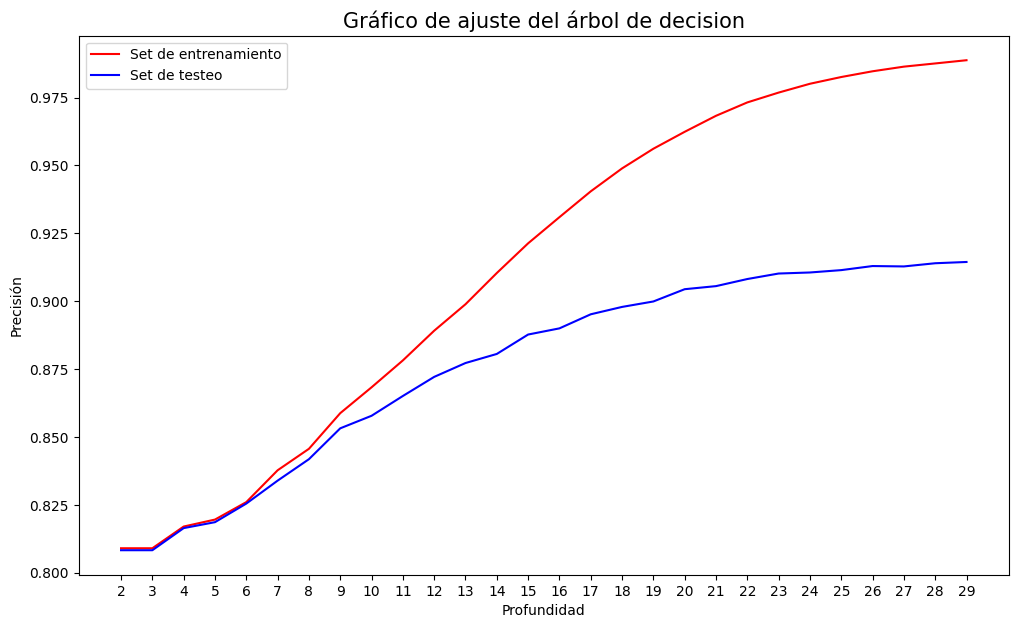

In [ ]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(2, 30))

for deep in max_deep_list:
    clf_3 = DecisionTreeClassifier(max_depth=deep, criterion='entropy')
    clf_3.fit(X_Train, Y_Train)
    train_prec.append(clf_3.score(X_Train, Y_Train))
    eval_prec.append(clf_3.score(X_Test, Y_Test))


plt.figure(figsize=(12,7))
plt.plot(max_deep_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del árbol de decision', fontsize = 15)
plt.legend()
plt.xticks([i for i in max_deep_list])
plt.ylabel('Precisión')
plt.xlabel('Profundidad')
plt.show()

In [ ]:
# observamos que el óptimo se logra en profundidad 9
clf_3 = DecisionTreeClassifier(max_depth=9, criterion='entropy')
clf_3.fit(X_Train, Y_Train)
y_pred = clf_3.predict(X_Test)
print('Accuracy: ', accuracy_score(Y_Test,y_pred))
print('Recall: ', recall_score(Y_Test,y_pred))
print('Feature importance: ', clf_3.feature_importances_)


Accuracy:  0.8532366523535607
Recall:  0.6472821397756687
Feature importance:  [0.13614279 0.11638887 0.56208194 0.03979423 0.04599894 0.02963538
 0.05961219 0.00899899 0.         0.00070771 0.00063896]


In [ ]:
entrega_pred = clf_3.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
# esta es la entrega n°1 (se usó depth = 30, muy overfitteado)

## 2. K-Vecinos

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Instanciamos un objeto de la clase KNeighborsClassifier

clf1 = KNeighborsClassifier(n_neighbors = 5)
clf1.fit(X_Train,Y_Train)
y_pred = clf1.predict(X_Test)

print('Accuracy: ', accuracy_score(Y_Test,y_pred), '\t', 'Recall: ', recall_score(Y_Test,y_pred))



c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy:  0.8754152151016771 	 Recall:  0.7047210300429184


In [ ]:
accur_train=[]
accur_test=[]
recall=[]
vecinos = list(range(2, 15))

for i in vecinos:
    clf1 = KNeighborsClassifier(n_neighbors = i)
    clf1.fit(X_Train,Y_Train)
    y_pred = clf1.predict(X_Test)
    y_pred_train = clf1.predict(X_Train)
    accur_train.append(accuracy_score(Y_Train,y_pred_train))
    accur_test.append(accuracy_score(Y_Test,y_pred))
    recall.append(recall_score(Y_Test,y_pred))


c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:2

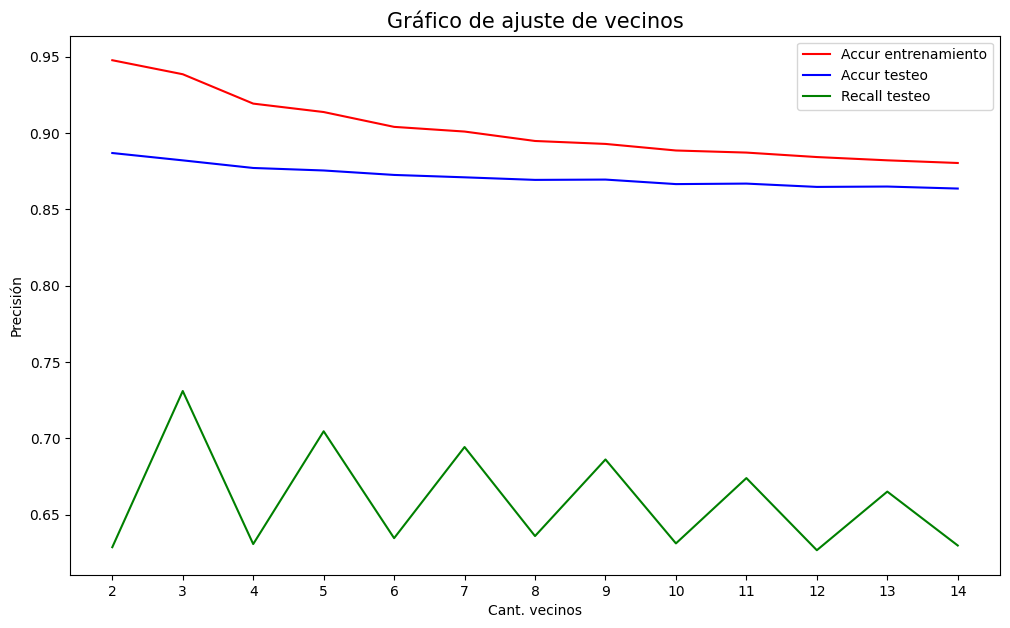

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(vecinos, accur_train, color='r', label='Accur entrenamiento')
plt.plot(vecinos, accur_test, color='b', label='Accur testeo')
plt.plot(vecinos, recall, color='g', label='Recall testeo')
plt.title('Gráfico de ajuste de vecinos', fontsize = 15)
plt.legend()
plt.xticks([i for i in vecinos])
plt.ylabel('Precisión')
plt.xlabel('Cant. vecinos')
plt.show()

In [ ]:
# Vemos que el óptimo se encuentra en 3
clf1 = KNeighborsClassifier(n_neighbors = 3)
clf1.fit(X_Train,Y_Train)
y_pred = clf1.predict(X_Test)
y_pred_train = clf1.predict(X_Train)
print('Accuracy:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.8820384023333063
Recall: 0.7310729613733905


In [ ]:
entrega_pred = clf1.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
#entrega 2

## 3. Regresion Logistica

In [5]:
from sklearn.linear_model import LogisticRegression

# Instanciamos el modelo y lo entrenamos

clf = LogisticRegression()

# Lo entrenamos

clf.fit(X_Train,Y_Train)

c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [6]:
y_pred = clf.predict(X_Test)
y_pred_train = clf.predict(X_Train)
print('Accuracy_Train:', accuracy_score(Y_Train,y_pred_train))
print('Accuracy_Test:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

Accuracy_Train: 0.8110982081369755
Accuracy_Test: 0.8086567285100867
Recall: 0.3526315789473684


## 4. ARBOL c/ CROSS VALIDATION Y WEIGHT DECISION

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
tree = DecisionTreeClassifier()
tree_scores = cross_validate(tree, X, y, cv=5, scoring = 'f1')
print(tree_scores)

{'fit_time': array([0.83158755, 0.8230629 , 0.80818105, 0.83506465, 0.82401252]), 'score_time': array([0.02103782, 0.02082372, 0.02223849, 0.02104211, 0.02199626]), 'test_score': array([0.83489499, 0.83615331, 0.84136285, 0.83542261, 0.83578537])}


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
weights = {0:1, 1:2}
clf5 = DecisionTreeClassifier(max_depth=9, class_weight=weights)
clf5.fit(X_Train, Y_Train)
y_pred = clf5.predict(X_Test)
print('Recall: ', recall_score(Y_Test,y_pred))
print('Accuracy: ', accuracy_score(Y_Test,y_pred))
print('Feature importance: ', clf5.feature_importances_)

Recall:  0.766695427092321
Accuracy:  0.8318075022279835
Feature importance:  [0.08342494 0.10086155 0.61474505 0.01909209 0.00736071 0.00989601
 0.05726823 0.01074369 0.00371782 0.00278048 0.         0.07156117
 0.01854826]


In [ ]:
clf6 = DecisionTreeClassifier()
balance = [{0:1,1:1}, {0:1,1:3}, {0:1,1:10}, {0:1,1:50}, {0:1,1:100}]
depths = list(range(3,30))
param_grid = dict(class_weight = balance, max_depth = depths)
model = GridSearchCV(clf6, param_grid=param_grid, cv=5, scoring ='f1')

In [ ]:
model.fit(X_Train, Y_Train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3},
                                          {0: 1, 1: 10}, {0: 1, 1: 50},
                                          {0: 1, 1: 100}],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29]},
             scoring='f1')

In [ ]:
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores hiperparámetros: {'class_weight': {0: 1, 1: 1}, 'max_depth': 29}
Mejor Score: 0.8104587472792526



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.230249,0.020181,0.015889,0.003011,"{0: 1, 1: 1}",3,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 3}",0.510653,0.519074,0.512759,0.512214,0.523358,0.515611,0.004822,123
1,0.270957,0.030158,0.013403,0.002134,"{0: 1, 1: 1}",4,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 4}",0.526852,0.497852,0.487114,0.514143,0.565131,0.518219,0.027108,122
2,0.296824,0.020121,0.011806,0.000751,"{0: 1, 1: 1}",5,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 5}",0.514291,0.541496,0.537039,0.534455,0.535260,0.532508,0.009429,119
3,0.326898,0.013964,0.012729,0.000398,"{0: 1, 1: 1}",6,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 6}",0.545191,0.581107,0.580183,0.573913,0.606544,0.577388,0.019598,110
4,0.356424,0.004617,0.012788,0.000728,"{0: 1, 1: 1}",7,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 7}",0.607330,0.598804,0.589645,0.588896,0.592857,0.595506,0.006867,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.765362,0.009035,0.022404,0.001025,"{0: 1, 1: 100}",25,"{'class_weight': {0: 1, 1: 100}, 'max_depth': 25}",0.734451,0.738131,0.737582,0.736739,0.739349,0.737251,0.001636,56
131,0.766761,0.010446,0.021671,0.000686,"{0: 1, 1: 100}",26,"{'class_weight': {0: 1, 1: 100}, 'max_depth': 26}",0.746146,0.747720,0.745729,0.747865,0.748255,0.747143,0.001008,51
132,0.775190,0.009334,0.022471,0.000577,"{0: 1, 1: 100}",27,"{'class_weight': {0: 1, 1: 100}, 'max_depth': 27}",0.750969,0.756282,0.754871,0.755789,0.756812,0.754945,0.002088,46
133,0.965797,0.156220,0.027401,0.004117,"{0: 1, 1: 100}",28,"{'class_weight': {0: 1, 1: 100}, 'max_depth': 28}",0.756450,0.764336,0.764101,0.764130,0.763017,0.762407,0.003014,43


In [ ]:
y_pred = model.predict(X_Test)
y_pred_train = model.predict(X_Train)
print('Accuracy_Train:', accuracy_score(Y_Train,y_pred_train))
print('Accuracy_Test:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

Accuracy_Train: 0.9946730221316014
Accuracy_Test: 0.9207040427772827
Recall: 0.830802415875755


In [ ]:
param_grid1 #guarde la grid de la primera corrida
best_params1 #guarde los mejores parametros de esa primera corrida

{'class_weight': {0: 1, 1: 3}, 'max_depth': 29}

In [ ]:
entrega_pred = model.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
#entrega 3 mejores hiperparámetros: {'class_weight': {0: 1, 1: 3}, 'max_depth': 29}

In [ ]:
#clf6 = DecisionTreeClassifier()
#balance = [{0:1,1:2}, {0:1,1:3}, {0:1,1:4}, {0:1,1:5}, {0:1,1:6}, {0:1,1:7}, {0:1,1:8}, {0:1,1:9}]
#depths = list(range(6,30))
#param_grid = dict(class_weight = balance, max_depth = depths)
#model = GridSearchCV(clf6, param_grid=param_grid, cv=5, scoring ='f1')
#Se ejecutó esto tambien, y dio otros hiperparam {'class_weight': {0: 1, 1: 2}, 'max_depth': 29}, con result casi identido

## 5. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', class_weight= {0: 1, 1: 2}, n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_Train, Y_Train)

In [ ]:
y_pred = clf.predict(X_Test)
y_pred_train = clf.predict(X_Train)
print('Accuracy_Train:', accuracy_score(Y_Train,y_pred_train))
print('Accuracy_Test:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

print('Feature importance: ', clf.feature_importances_)

Accuracy_Train: 0.9917563498386378
Accuracy_Test: 0.9264967998055578
Recall: 0.8264883520276101
Feature importance:  [0.22028964 0.21702547 0.28417576 0.18681936 0.04233208 0.01148618
 0.02512511 0.00716369 0.00158046 0.00291583 0.00108642]


In [ ]:
entrega_pred = clf.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
# entrega 4

## 6. Regresion polinomica múltiple 

In [ ]:
# cambio de estrategia.
# En vez de clasificar en 0/1. Vamos a armar un modelo que prediga el precio de la propiedad.
# Luego clasificamos la predicción de precio en 0/1 y evaluamos si mejora el modelo. 

## 6. Random Forest con columnas adic PLN

In [ ]:
# agrego a mi set x la(s) nueva(s) columna(s)
columnas_x = ['lat', 'lon', 'bathrooms', 'desc_tot_words', 'Apartamento', 'Casa', 'Otro', 'Lote', 'Local comercial', 'Finca', 'Oficina', 'palab_cara']
columna_y = ['caro']

X = np.array(data_model.loc[:,columnas_x])
y = np.array(data_model.loc[:,columna_y])
X_testigo_entrega = np.array(data_model_test.loc[:,columnas_x])

from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.25, random_state=0, stratify=y)

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', class_weight= {0: 1, 1: 2}, n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_Train, Y_Train)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_12932\4145669491.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_Train, Y_Train)


RandomForestClassifier(class_weight={0: 1, 1: 2}, n_jobs=-1, oob_score=True,
                       random_state=42)

In [ ]:
y_pred = clf.predict(X_Test)
y_pred_train = clf.predict(X_Train)
print('Accuracy_Train:', accuracy_score(Y_Train,y_pred_train))
print('Accuracy_Test:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

print('Feature importance: ', clf.feature_importances_)

Accuracy_Train: 0.994072133626801
Accuracy_Test: 0.9293121607388803
Recall: 0.8297670405522002
Feature importance:  [0.2081463  0.20748838 0.26791634 0.1784753  0.03121647 0.0109374
 0.02259131 0.00751247 0.0019063  0.00254511 0.00097034 0.06029428]


In [ ]:
entrega_pred = clf.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
# entrega 5

## 7. Ultimo Random Forest con el feature de bedrooms

In [4]:
# agrego a mi set x la(s) nueva(s) columna(s)
columnas_x = ['lat', 'lon', 'bathrooms', 'desc_tot_words', 'Apartamento', 'Casa', 'Otro', 'Lote', 'Local comercial', 'Finca', 'Oficina', 'palab_cara', 'bedrooms']
columna_y = ['caro']

X = np.array(data_model.loc[:,columnas_x])
y = np.array(data_model.loc[:,columna_y])
X_testigo_entrega = np.array(data_model_test.loc[:,columnas_x])

from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.25, random_state=0, stratify=y)

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [5]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', class_weight= {0: 1, 1: 2}, n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_Train, Y_Train)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_9560\4145669491.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_Train, Y_Train)


RandomForestClassifier(class_weight={0: 1, 1: 2}, n_jobs=-1, oob_score=True,
                       random_state=42)

In [6]:
y_pred = clf.predict(X_Test)
y_pred_train = clf.predict(X_Train)
print('Accuracy_Train:', accuracy_score(Y_Train,y_pred_train))
print('Accuracy_Test:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

print('Feature importance: ', clf.feature_importances_)

Accuracy_Train: 0.9955979853356198
Accuracy_Test: 0.9335048205460585
Recall: 0.8365832614322692
Feature importance:  [0.19679065 0.19580597 0.25712619 0.16787669 0.0357479  0.01049792
 0.02145828 0.00608073 0.00171772 0.00186287 0.0009749  0.05791261
 0.04614757]


In [ ]:
entrega_pred = clf.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
# entrega 6

#### Jugar con predict_proba para mejorar recall (en detrimento de accuracy)

In [7]:
#obtenemos el vector pred_proba sobre el conjunto X_Test 
y_predproba_test = clf.predict_proba(X_Test)

# me quedo con la 2da columna, que es la que predice la clase de los 1's (caros)
y_predproba_test = y_predproba_test[:,1]
y_predproba_test

array([0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.02])

In [24]:
# defino cortes de probabilidad para probar como se comporta el modelo desde prob 0.5 (la standard) hasta prob 0.34 
probas=np.linspace(0.5,0.1,17)
def armar_matriz(y_predproba_test,probas):
    ''' Esta función arma la matriz de predicciones
        En cada columna devuleve la predicción para su ´probabilidad asociada en el vector probas'''
    matriz_proba = np.round(y_predproba_test,0)
    for i in range(1,len(probas)):
        aux=y_predproba_test/probas[i]
        for j in range (0,len(aux)):
            if aux[j]<0.5:
                aux[j] = 0
            else:
                aux[j] = 1    
        matriz_proba = np.vstack((matriz_proba,aux))
        mat = matriz_proba.T
    return mat

In [25]:
mat_pred = armar_matriz(y_predproba_test,probas)

In [26]:
with np.printoptions(edgeitems=50):
    print(mat_pred)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

In [27]:
acc = []
rec = []
for i in range (0,len(probas)):
    acc.append(accuracy_score(Y_Test,mat_pred[:,i]))
    rec.append(recall_score(Y_Test,mat_pred[:,i]))
    print('Accuracy_Test',round(probas[i]*100,2),'% :\t', round(acc[i],2))
    print('Recall_Test',round(probas[i]*100,2),'% :\t', round(rec[i],2))
    print('\n')


Accuracy_Test 50.0 % :	 0.93
Recall_Test 50.0 % :	 0.84


Accuracy_Test 47.5 % :	 0.91
Recall_Test 47.5 % :	 0.93


Accuracy_Test 45.0 % :	 0.9
Recall_Test 45.0 % :	 0.93


Accuracy_Test 42.5 % :	 0.9
Recall_Test 42.5 % :	 0.94


Accuracy_Test 40.0 % :	 0.9
Recall_Test 40.0 % :	 0.94


Accuracy_Test 37.5 % :	 0.89
Recall_Test 37.5 % :	 0.94


Accuracy_Test 35.0 % :	 0.89
Recall_Test 35.0 % :	 0.95


Accuracy_Test 32.5 % :	 0.89
Recall_Test 32.5 % :	 0.95


Accuracy_Test 30.0 % :	 0.88
Recall_Test 30.0 % :	 0.96


Accuracy_Test 27.5 % :	 0.87
Recall_Test 27.5 % :	 0.96


Accuracy_Test 25.0 % :	 0.87
Recall_Test 25.0 % :	 0.96


Accuracy_Test 22.5 % :	 0.86
Recall_Test 22.5 % :	 0.96


Accuracy_Test 20.0 % :	 0.85
Recall_Test 20.0 % :	 0.97


Accuracy_Test 17.5 % :	 0.84
Recall_Test 17.5 % :	 0.97


Accuracy_Test 15.0 % :	 0.83
Recall_Test 15.0 % :	 0.97


Accuracy_Test 12.5 % :	 0.82
Recall_Test 12.5 % :	 0.98


Accuracy_Test 10.0 % :	 0.8
Recall_Test 10.0 % :	 0.98




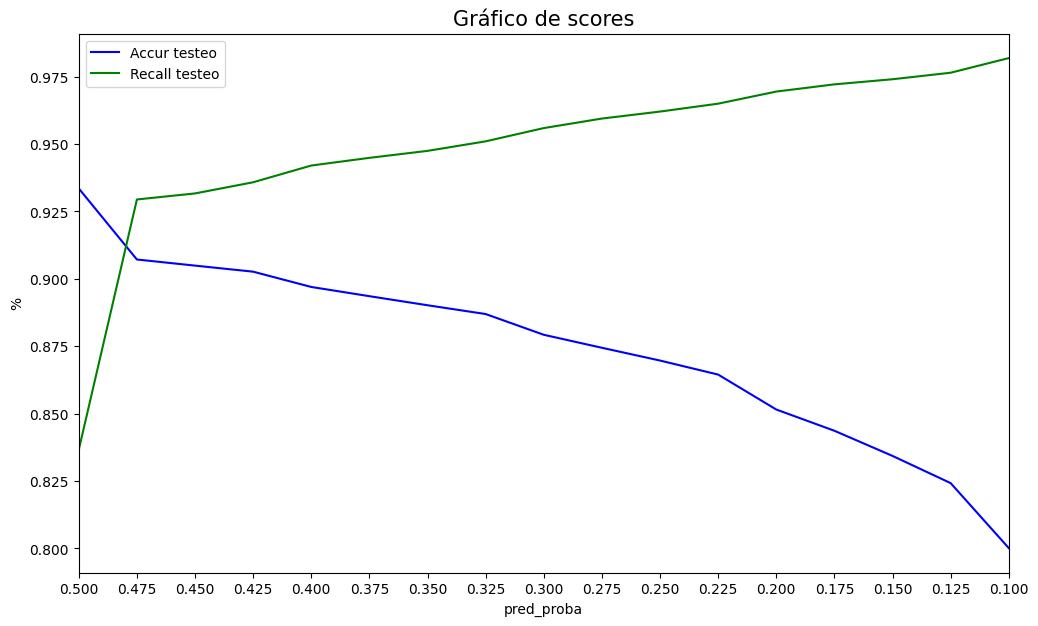

In [29]:
plt.figure(figsize=(12,7))
plt.plot(probas, acc, color='b', label='Accur testeo')
plt.plot(probas, rec, color='g', label='Recall testeo')
plt.title('Gráfico de scores', fontsize = 15)
plt.legend()
plt.xticks([round(i,3) for i in probas])
plt.xlim(max(probas), min(probas))
plt.ylabel('%')
plt.xlabel('pred_proba')
plt.show()

In [295]:
# podemos concluir que elevamos notablemente el recall sacrificando poco el accuracy
# me voy a quedar con el valor de 0.275, que mantiene el accuracy en un 87,5% y levanta el recall 
# hasta más de un 95% aproximadamente.

In [31]:
#obtenemos el vector pred_proba sobre el conjunto X_testigo_entrega 
y_predproba_test_entrega = clf.predict_proba(X_testigo_entrega)

# me quedo con la 2da columna, que es la que predice la clase de los 1's (caros)
y_predproba_test_entrega = y_predproba_test_entrega[:,1]
y_predproba_test_entrega

array([0.98, 0.  , 0.  , ..., 0.03, 0.13, 0.  ])

In [32]:
mat_pred_entrega = armar_matriz(y_predproba_test_entrega,probas)

entrega_pred = mat_pred_entrega[:,7] #0.275 es el 7mo indice del array
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)

